In [1]:
# ====== Setup & Download ======
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download dataset
file_id = '1ckAYpVnT-wqTclxnvpld6dWp8Q1QZv7b'
gdown.download(id=file_id, output='fraudTrain.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ckAYpVnT-wqTclxnvpld6dWp8Q1QZv7b
To: d:\github\Fraud_API\model\fraudTrain.csv
100%|██████████| 28.3k/28.3k [00:00<00:00, 120kB/s]


'fraudTrain.csv'

In [2]:
# ====== Load Data ======
df = pd.read_csv("fraudTrain.csv")
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

Dataset loaded: 1000 rows × 5 columns


In [3]:
# ====== Basic Info ======
#print("\nBasic Info:")
#print(df.info())

In [4]:
# ====== Missing Values & Duplicate Rows Check ======
print("\nMissing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\nDuplicate Rows:")
duplicate = df.duplicated().sum()
print(duplicate)


Missing Values:
Series([], dtype: int64)

Duplicate Rows:
0


In [5]:
# ====== Skewness Check ======
print("\nSkewness Check:")
skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed_features)

print("\nRecommendation:")
for col, skew in skewed_features.items():
    if abs(skew) > 1:
        print(f"{col} is highly skewed (skew={skew:.2f}). Suggest: Apply log or sqrt transform.")
    elif abs(skew) > 0.5:
        print(f"{col} is moderately skewed (skew={skew:.2f}). Transform optional.")
    else:
        print(f"{col} is fairly symmetric (skew={skew:.2f}). No action needed.")


Skewness Check:
label             4.135689
amount            1.867839
transaction_id    0.000000
dtype: float64

Recommendation:
label is highly skewed (skew=4.14). Suggest: Apply log or sqrt transform.
amount is highly skewed (skew=1.87). Suggest: Apply log or sqrt transform.
transaction_id is fairly symmetric (skew=0.00). No action needed.


In [6]:
# ====== Outlier Detection (IQR Method) ======
print("\n Outlier Check (IQR Method):")
for col in df.select_dtypes(include=['number']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers detected.")
    else:
        print(f"{col}: No significant outliers.")


 Outlier Check (IQR Method):
transaction_id: No significant outliers.
amount: 43 outliers detected.
label: 50 outliers detected.


In [7]:
# ====== Correlation Analysis ======
print("\n Correlation Matrix (Top correlated pairs):")
correlation = df.corr(numeric_only=True)
cor_matrix = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr = cor_matrix[(cor_matrix < 1) & (cor_matrix > 0.7)]
print(top_corr)

print("\n Recommendation:")
for (f1, f2), corr_val in top_corr.items():
    print(f" {f1} & {f2} have high correlation ({corr_val:.2f}). Suggest: Keep only one or apply dimensionality reduction (e.g., PCA).")


 Correlation Matrix (Top correlated pairs):
Series([], dtype: float64)

 Recommendation:


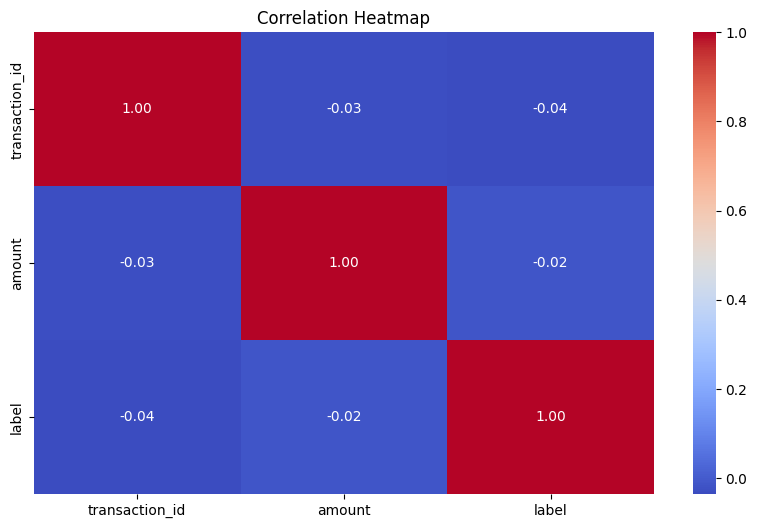

In [8]:
# ====== Heatmap ======
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [9]:
# ====== Preprocessing ======
# Log transform amount
df['amount_log'] = np.log1p(df['amount'])

# One-hot encoding
categorical_cols = ['merchant_type', 'device_type']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# SMOTE preparation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['label', 'transaction_id', 'amount'])
y = df_encoded['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
# ====== TensorFlow Model Training ======
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# Scaling fitur numerik
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

# Definisi arsitektur model
model = keras.Sequential([
    layers.Input(shape=(X_res_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Output biner
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# Training
history = model.fit(
    X_res_scaled, y_res,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6184 - loss: 0.6542 - precision: 0.4815 - recall: 0.2281 - val_accuracy: 0.1086 - val_loss: 0.8945 - val_precision: 1.0000 - val_recall: 0.1086
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6604 - loss: 0.6205 - precision: 0.5788 - recall: 0.3465 - val_accuracy: 0.4408 - val_loss: 0.8341 - val_precision: 1.0000 - val_recall: 0.4408
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6826 - loss: 0.5933 - precision: 0.6277 - recall: 0.3772 - val_accuracy: 0.5263 - val_loss: 0.7763 - val_precision: 1.0000 - val_recall: 0.5263
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7015 - loss: 0.5797 - precision: 0.6396 - recall: 0.4671 - val_accuracy: 0.5033 - val_loss: 0.8202 - val_precision: 1.0000 - val_recall: 0.5033
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7097 - loss: 0.5554 - precision: 0.6667 - recall: 0.4518 - val_accuracy: 0.5987 - val_loss: 0.7381 - va

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9500    0.9000    0.9243       190
           1     0.0500    0.1000    0.0667        10

    accuracy                         0.8600       200
   macro avg     0.5000    0.5000    0.4955       200
weighted avg     0.9050    0.8600    0.8814       200



<Figure size 600x400 with 0 Axes>

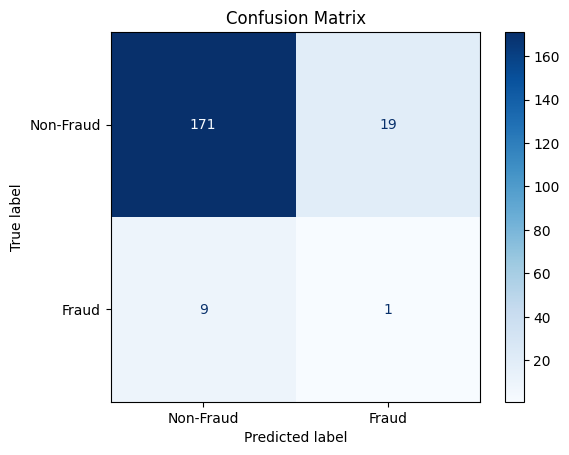

In [ ]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype("int32")

print("\nClassification Report:")
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [12]:
# ====== Load Sample Data Baru ======
sample_data = {
    'transaction_id': 1001,
    'amount': 104.88,
    'merchant_type': 'electronics',
    'device_type': 'tablet'
}

sample_df = pd.DataFrame([sample_data])
sample_df['amount_log'] = np.log1p(sample_df['amount'])

combined = pd.concat([df[['merchant_type', 'device_type']], sample_df[['merchant_type', 'device_type']]])
combined_encoded = pd.get_dummies(combined, drop_first=True)
sample_encoded = combined_encoded.iloc[[-1]].reset_index(drop=True)

numerical_cols = ['amount_log']
sample_final = pd.concat([sample_df[numerical_cols].reset_index(drop=True), sample_encoded], axis=1)

for col in X_train.columns:
    if col not in sample_final.columns:
        sample_final[col] = 0

sample_final = sample_final[X_train.columns]
sample_final_scaled = scaler.transform(sample_final)

new_prediction = model.predict(sample_final_scaled)
label_pred = 'Fraud' if new_prediction[0][0] > 0.5 else 'Non-Fraud'

print(f"\nPrediksi untuk data baru:")
print(f" Label prediksi: {label_pred}")
print(f" Probabilitas Fraud: {new_prediction[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Prediksi untuk data baru:
 Label prediksi: Fraud
 Probabilitas Fraud: 0.7316


In [ ]:
import os
import pickle

os.makedirs("model", exist_ok=True)

model.save("model/fraud_model_tf.h5")

with open("model/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

model_columns = list(X_train.columns)
with open("model/model_columns.pkl", "wb") as f:
    pickle.dump(model_columns, f)

In [ ]:
import os
import joblib
import json
import tensorflow as tf

os.makedirs("model", exist_ok=True)

model.save("model/fraud_model_tf.keras")  # ✅ format baru

joblib.dump(scaler, "model/scaler.pkl")

with open("model/model_columns.json", "w") as f:
    json.dump(list(X_train.columns), f)

print("✅ Model dan preprocessing tersimpan di folder model/")


✅ Model dan preprocessing tersimpan di folder model/
